# Lab 1 | Regressions | Walkthrough

In this walkthrough, our goal will be to use a regression to predict the salary of an NHL player. (The NHL is the world's best professional ice hockey league.)

To predict the salaries, we will use a dataset containing various metrics about every player in the pre-cited league during the 2016-17 season.

### Step 1 | Exploratory Data Analysis and Data Cleaning

The first step in any project is to load and explore the data. The exploration, commonly referred to as Exploratory Data Analysis (EDA), is essential as it helps us spot weaknesses in the data (duplicate rows, missing data, outliers, etc.) and can guide our decision in how to manipulate it before fitting a model (or while trying to improve it).

In [2]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [9]:
# Load the dataset
nhl = pd.read_csv('./data/nhl_2016_17.csv')
display(nhl.head())
print(nhl.shape)

,name,born,height,weight,position,games_played,goals,assists,plus_minus,penalty_minutes,salary
0,Spencer Abbott,1988,69,170,LW,1,0,0,0,0,$575'000.00
1,Justin Abdelkader,1987,74,218,LW,64,7,14,-20,50,$5'500'000.00
2,Pontus Aberg,1993,71,196,LW,15,1,1,-2,4,$842'500.00
3,Noel Acciari,1991,70,208,C,29,2,3,3,16,$892'500.00
4,Kenny Agostino,1992,72,202,LW,7,1,2,0,2,$625'000.00


(888, 11)


When working with a dataset, often the first challenge is understanding what each of the rows mean. Thus, it is often advised to carefully read the data-dictionary. In our case, the columns represent the following:
- `name`: A player's name
- `born`: A player's year of birth
- `heigh`: A player's height in inches
- `weight`: A player's weight in pounds
- `position`: A player's position
- `games_played`: The number of games a player played during the season
- `goals`: The number of goals scored by the player during the season
- `assists`: The number of assists recorded by the player during the season
- `plus_minus`: The number of times a player was on the ice when his team scored a goal minus the number of times he was on the ice when the opposing team scored a goal at even strength or short-handed
- `penalty_minutes`: The number of penalty minutes the player collected
- `salary`: A player's salary

Now that we understand our variables, we can start with the EDA. 

##### Data Cleaning: Null and Missing Values 

One thing to look at are the missing values, which one needs to decide how to handle on a case-by-case basis. This can involve:

- Deleting an entire column: If too many values are missing and the column is not critical
- Deleting rows with one, some, or all variables missing: If only a small pencentage of rows are affected on important variables
- Manually collect the missing data: Tedious and could introduce measurement deviations
- Input the mean, median, or an arbitrary number: Sometimes hard to justify and required expert knowledge

We notice that there are 14 players with missing values for their salary. Since 14/888 rows are not a lot, we will simply drop them.

In [12]:
# Lookup the missing values
print(nhl.isna().sum())

# Remove the players with missing salaries
nhl.dropna(axis=0, subset='salary', inplace=True)
print(f'remaining number of rows: {len(nhl)}')

name               0
born               0
height             0
weight             0
position           0
games_played       0
goals              0
assists            0
plus_minus         0
penalty_minutes    0
salary             0
dtype: int64
remaining number of rows: 874


##### Data Cleaning: Converting the data type of a column (i.e. string to int; categorical to discrete; etc.)

Another thing to look at are the datatypes of the columns and check that they are in accordance with what we expect.

We notice that the numerical variables are in `int64` while the categorical variables are in `object`, which is as expected. The one exception is the `salary` column, which is a string when it should be a number. Hence, it is something to fix before we can fit the model.

In [48]:
# List the datatypes of all columns
print(nhl.dtypes)

# Transform the salary column to numeric
nhl['salary'] = pd.to_numeric(
    nhl['salary'].apply(
        lambda sal: sal.replace("$", "").replace("'", "")
    )
)
nhl.head()

name               object
born                int64
height              int64
weight              int64
position           object
games_played        int64
goals               int64
assists             int64
plus_minus          int64
penalty_minutes     int64
salary             object
dtype: object


,name,born,height,weight,position,games_played,goals,assists,plus_minus,penalty_minutes,salary
0,Spencer Abbott,1988,69,170,LW,1,0,0,0,0,575000.0
1,Justin Abdelkader,1987,74,218,LW,64,7,14,-20,50,5500000.0
2,Pontus Aberg,1993,71,196,LW,15,1,1,-2,4,842500.0
3,Noel Acciari,1991,70,208,C,29,2,3,3,16,892500.0
4,Kenny Agostino,1992,72,202,LW,7,1,2,0,2,625000.0


##### Data Exploration: Summary Statistics and Data Visualization

We can then turn our attention to the numerical variables. With `df.describe()`, we can easily get a lot of summary statistics for them. The `.transpose()` method often makes the output more readable, especially when there are a lot of variables being described.  This is a way to get a good sense for the data and find potential outliers. However, plotting might be just as good to do this.

Note that we will use histograms in this example, which are usually the standard (especially when it comes to looking at the general distribution and spotting outliers), but scatterplots, boxplots, etc. are also powerful visualizations.

,count,mean,std,min,25%,50%,75%,max
born,874.0,1.990049e+03,4.400990e+00,1972.0,1987.0,1991.0,1993.0,1998.0
height,874.0,7.308238e+01,2.105485e+00,66.0,72.0,73.0,75.0,81.0
weight,874.0,2.008432e+02,1.506008e+01,157.0,190.0,200.0,210.0,265.0
games_played,874.0,5.042563e+01,2.930789e+01,1.0,21.0,61.0,78.0,82.0
goals,874.0,7.657895e+00,8.633077e+00,0.0,1.0,5.0,12.0,44.0
assists,874.0,1.284096e+01,1.277629e+01,0.0,2.0,9.0,20.0,70.0
plus_minus,874.0,-3.775744e-01,9.945982e+00,-34.0,-5.0,-1.0,4.0,34.0
penalty_minutes,874.0,2.502860e+01,2.391250e+01,0.0,6.0,20.0,35.0,154.0
salary,874.0,2.325289e+06,2.298253e+06,575000.0,742500.0,925000.0,3700000.0,14000000.0


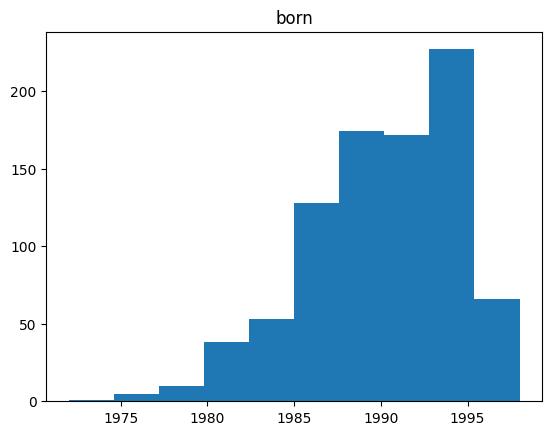

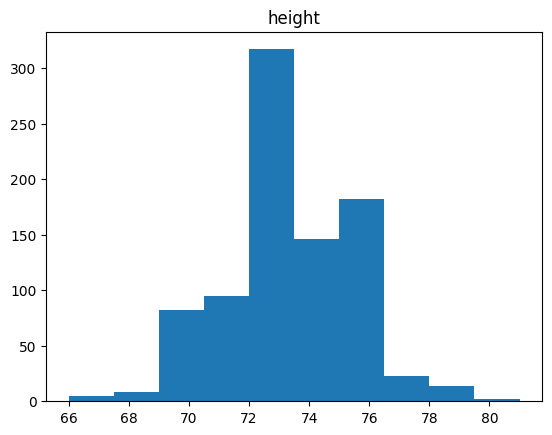

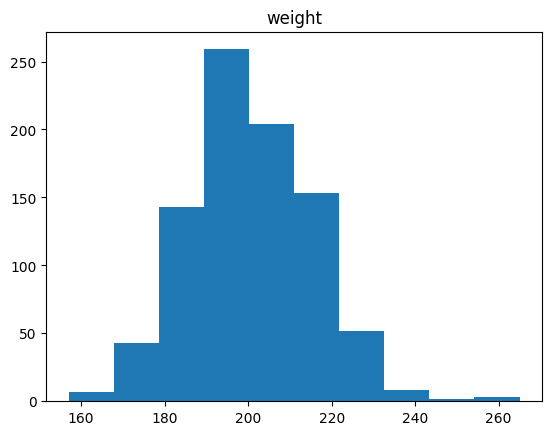

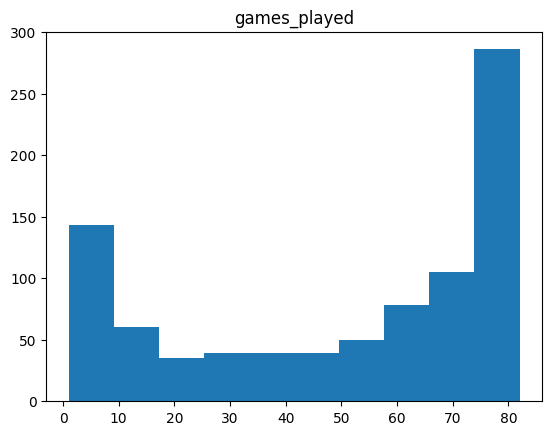

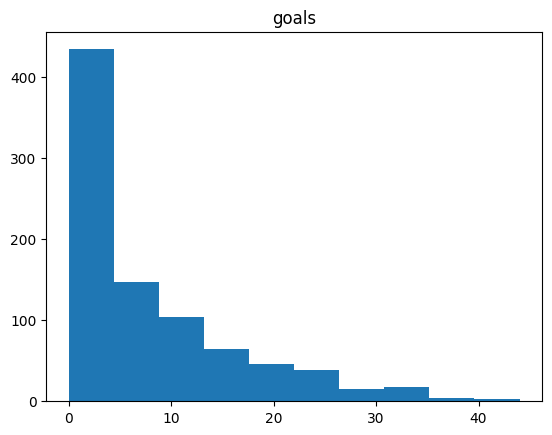

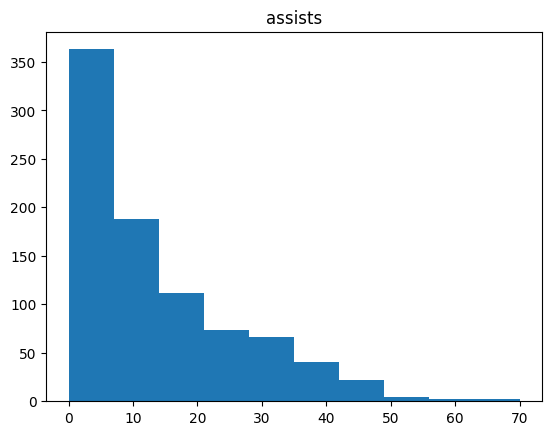

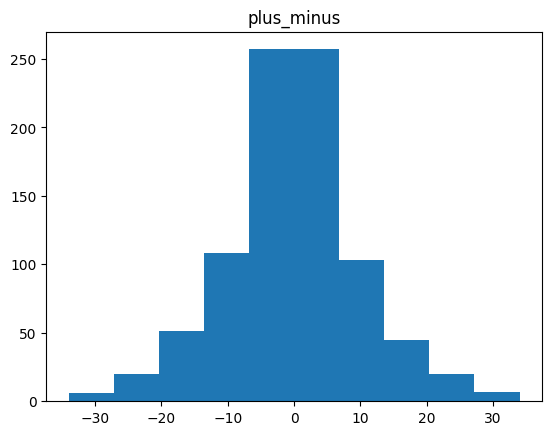

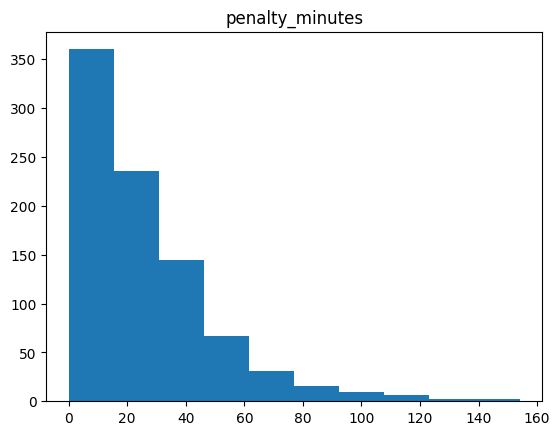

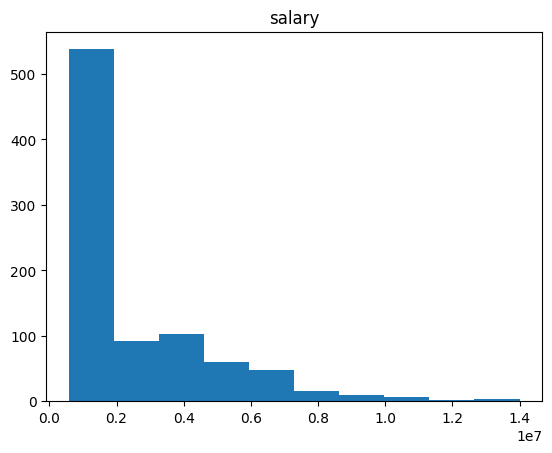

In [5]:
# Tip: use `display` to essentially "print" the output of your command
display(nhl.describe().transpose())

# Plot all numerical variables
for col in nhl.select_dtypes(['int64', 'float64']).columns:
    fig, ax = plt.subplots()  # Note:  we didn't specify the figure size argument;
    # the default figsize gives us an aspect ratio of 6.4:4.8
    ax.hist(nhl[col])
    ax.set_title(col)
    plt.show()

As mentioned above, other types of visualizations are also very powerful for EDA. The `Seaborn` library is quite handy as it allows us to easily create graphs. Below are examples of boxplots, scatterplots, and pairplots.

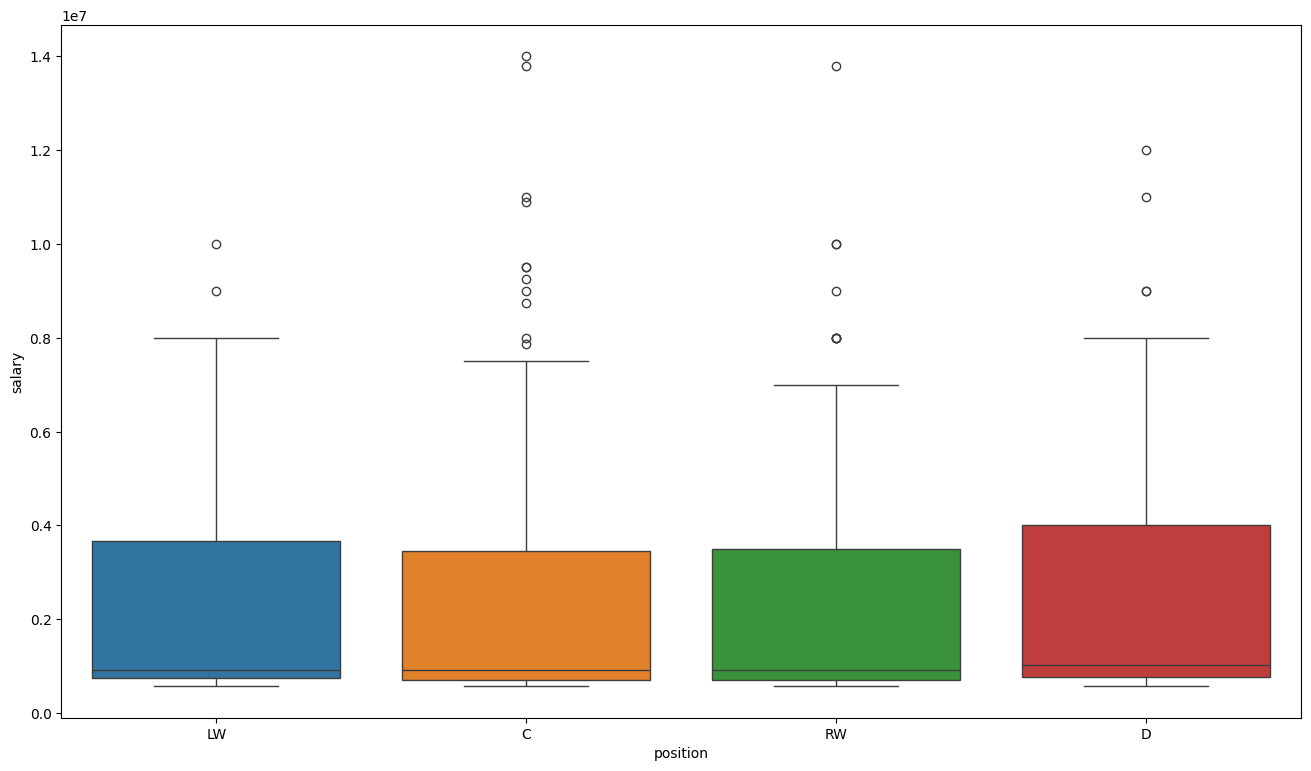

In [10]:
# Boxplot displaying the salary per position
fig, ax = plt.subplots(figsize=(16, 9))  
# 16:9 is the most common widescreen aspect ratio for computers & TVs;
# compare the size/shape of the previous figures to the figure that follows

# Use Seaborn's boxplot on the axes object
sns.boxplot(x='position', y='salary', hue='position', data=nhl, ax=ax)
plt.show()

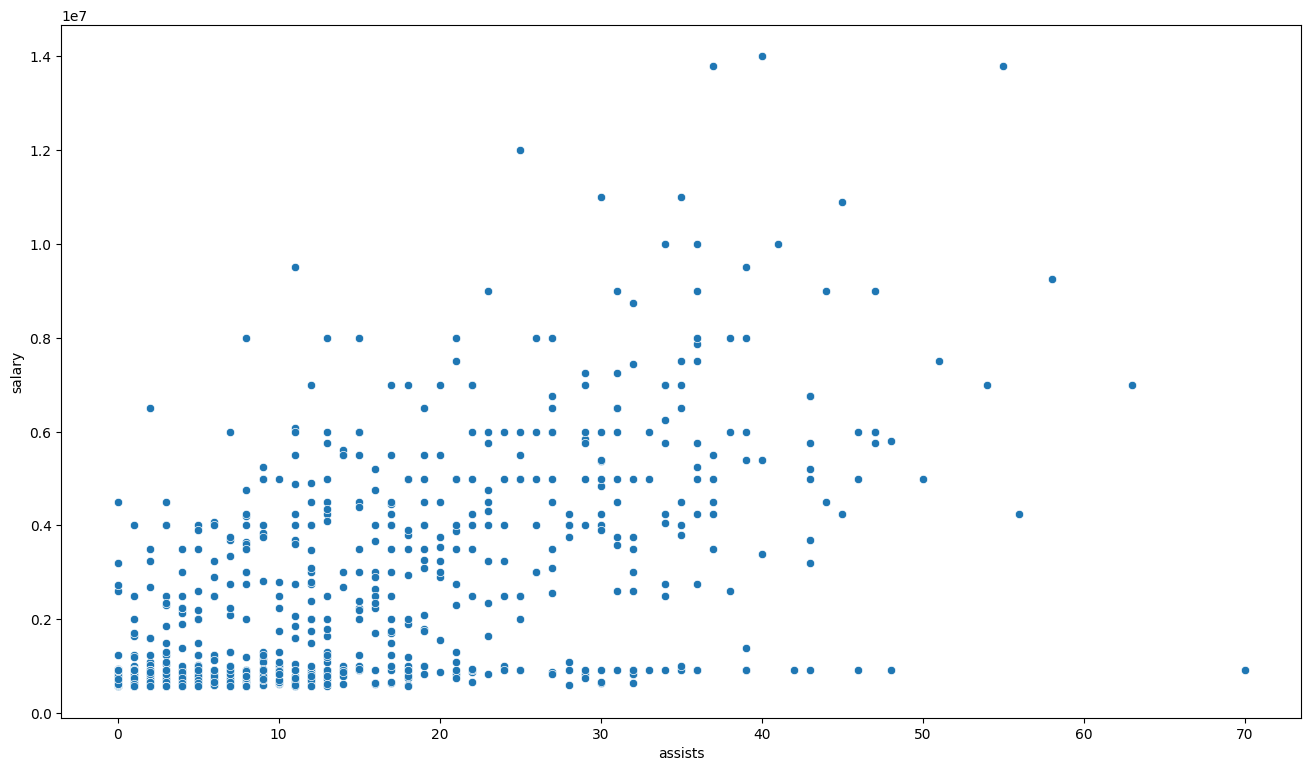

In [11]:
# Scatterplot displaying the relationship between assists and salary
fig, ax = plt.subplots(figsize=(16, 9))
# Use Seaborn's scatterplot on the axes object
sns.scatterplot(x='assists', y='salary', data=nhl, ax=ax)
plt.show()

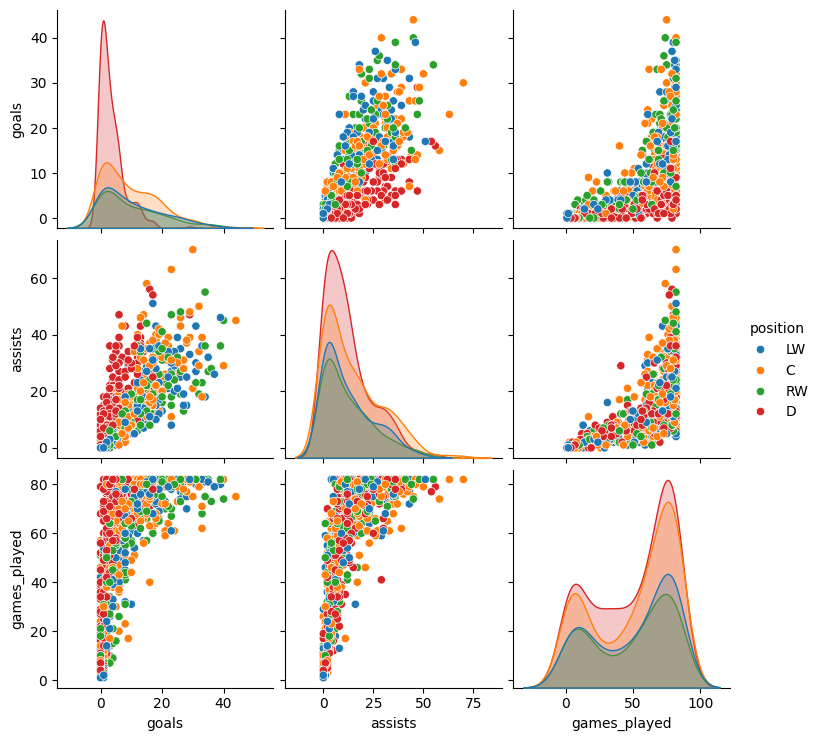

In [12]:
# Pairplot on goals, assists, and games_played with a hue on position
sns.pairplot(nhl, vars = ['goals', 'assists', 'games_played'], hue='position')

array([[<Axes: xlabel='goals', ylabel='goals'>,
        <Axes: xlabel='assists', ylabel='goals'>,
        <Axes: xlabel='games_played', ylabel='goals'>],
       [<Axes: xlabel='goals', ylabel='assists'>,
        <Axes: xlabel='assists', ylabel='assists'>,
        <Axes: xlabel='games_played', ylabel='assists'>],
       [<Axes: xlabel='goals', ylabel='games_played'>,
        <Axes: xlabel='assists', ylabel='games_played'>,
        <Axes: xlabel='games_played', ylabel='games_played'>]],
      dtype=object)

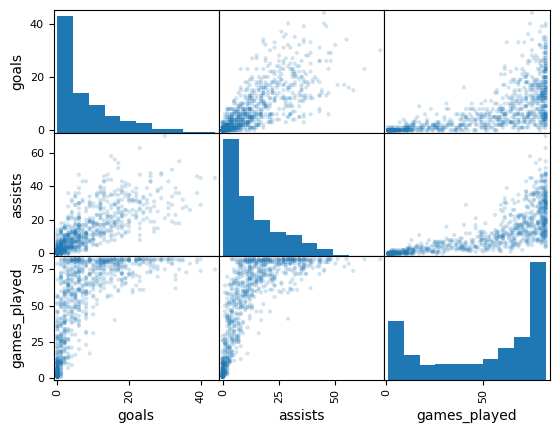

In [13]:
# Pairwise scatter_matrix plot using the pandas library
pd.plotting.scatter_matrix(nhl.loc[:, ['goals', 'assists', 'games_played']], alpha=0.2)

Note: `sns.pairplot` and `pd.plotting.scatter_matrix` work in similar ways by creating a matrix of scatterplots for specified variables, but are offered by different libraries (`Seaborn` vs `pandas`). Each library/package will have it's own specifications that might be slightly different.  

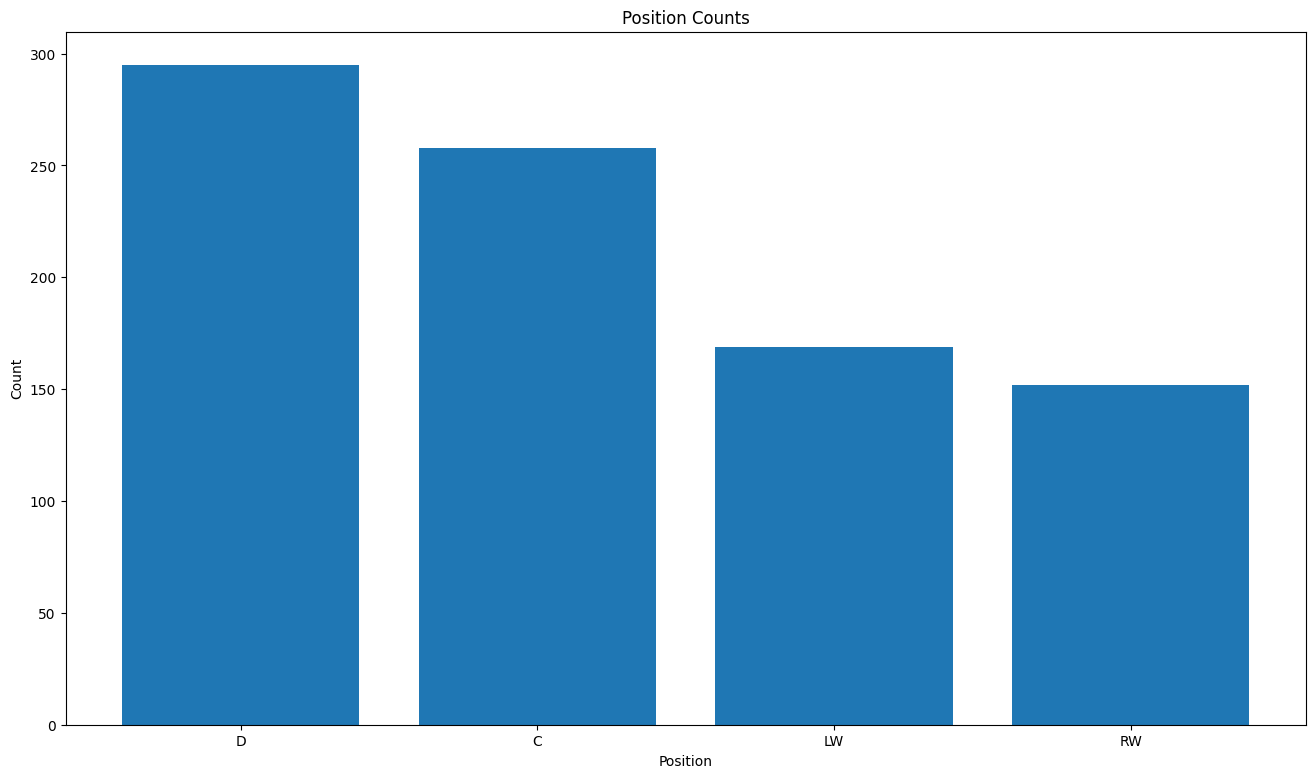

In [14]:
# Plot the categorical column
position_counts = nhl['position'].value_counts()


fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(position_counts.index, position_counts.values)
ax.set_title('Position Counts')
ax.set_xlabel('Position')
ax.set_ylabel('Count')

# Display the plot
plt.show()

##### Data Cleaning: Converting Categorical Variables to Dummies

It is often necessary to convert the categorical variables to numerical values so that the model can interpret them. In other words, many python packages can only peform analyses on numbers, so you might need to convert string categories with numerical representations. 

Today we will make dummy variables of the `position` column.

In [49]:
# Create dummy variables for the "position" column
nhl_dummies = pd.get_dummies(nhl['position'], drop_first=True)
nhl_dummies = nhl_dummies.rename(columns={"D": "position_D", "LW": "position_LW", "RW": "position_RW"})

# Add the new columns to the orginal dataframe
nhl = pd.concat([nhl, nhl_dummies], axis=1)

It is important to note that when we generate dummy variables we have to watch out for multicollinearity, which is why we use the `drop_first=True` argument (this removes one of the outcomes to avoid multicollinearity). We will learn more about this in future labs and assignments, as well as get more practice creating dummy variables and performing one-hot encoding in future weeks.

In [30]:
#check your work
nhl.head()

,name,born,height,weight,position,games_played,goals,assists,plus_minus,penalty_minutes,salary,position_D,position_LW,position_RW
0,Spencer Abbott,1988,69,170,LW,1,0,0,0,0,575000.0,False,True,False
1,Justin Abdelkader,1987,74,218,LW,64,7,14,-20,50,5500000.0,False,True,False
2,Pontus Aberg,1993,71,196,LW,15,1,1,-2,4,842500.0,False,True,False
3,Noel Acciari,1991,70,208,C,29,2,3,3,16,892500.0,False,False,False
4,Kenny Agostino,1992,72,202,LW,7,1,2,0,2,625000.0,False,True,False


##### Data Cleaning: Removing Duplicate Rows

Another thing you should always check is that you don't have any duplicate rows. For example, in our hockey dataset, each row should represent a unique hockey player. We can check for duplicate rows by ensuring none of the names of the `name` column occur more than once. 

In [31]:
# 3 ways to check for duplicate rows:

# 1. Count how many times each name occurs in the `name` column, and see if any name appears more than once
print(f'Most occurances of the same name: {nhl["name"].value_counts().max()}')

# 2. Check to make sure the number of rows equals the number of unique values in the `name` column
print(len(nhl) == len(nhl.loc[:, "name"].unique()))

# 3. Drop duplicate rows and save it
nhl = nhl.drop_duplicates()
nhl.head()

Most occurances of the same name: 1
True


,name,born,height,weight,position,games_played,goals,assists,plus_minus,penalty_minutes,salary,position_D,position_LW,position_RW
0,Spencer Abbott,1988,69,170,LW,1,0,0,0,0,575000.0,False,True,False
1,Justin Abdelkader,1987,74,218,LW,64,7,14,-20,50,5500000.0,False,True,False
2,Pontus Aberg,1993,71,196,LW,15,1,1,-2,4,842500.0,False,True,False
3,Noel Acciari,1991,70,208,C,29,2,3,3,16,892500.0,False,False,False
4,Kenny Agostino,1992,72,202,LW,7,1,2,0,2,625000.0,False,True,False


We have finally finished the data cleaning! Remember, this is usually 80% of the work... so now, let's turn to the actual machine learning!

In [32]:
# Display the cleaned data
display(nhl.head())

,name,born,height,weight,position,games_played,goals,assists,plus_minus,penalty_minutes,salary,position_D,position_LW,position_RW
0,Spencer Abbott,1988,69,170,LW,1,0,0,0,0,575000.0,False,True,False
1,Justin Abdelkader,1987,74,218,LW,64,7,14,-20,50,5500000.0,False,True,False
2,Pontus Aberg,1993,71,196,LW,15,1,1,-2,4,842500.0,False,True,False
3,Noel Acciari,1991,70,208,C,29,2,3,3,16,892500.0,False,False,False
4,Kenny Agostino,1992,72,202,LW,7,1,2,0,2,625000.0,False,True,False


### Step 2 | Create/fit the regression

##### StatsModels

Running regressions is likely a very familiar concept for everyone. This can easily be done in python with the `StatsModels` library.

Let's imagine that we want to predict `salary` with `goals` and a constant: $ \boxed{salary_i = \beta_0 + \beta_1 \cdot goals_i + \varepsilon_i} $   
We want to view the output which displays the statistical metrics of the model. 

In [52]:
# Model 1: Regress the salary on goals and a constant
# ols specifies to fit a linear regression
regression1 = smf.ols('salary ~ goals', data=nhl).fit()
regression1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     305.9
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           6.06e-59
Time:                        00:34:20   Log-Likelihood:                -13910.
No. Observations:                 874   AIC:                         2.782e+04
Df Residuals:                     872   BIC:                         2.783e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.286e+06   8.95e+04     14.375      0.000    1.11e+06    1.46e+06
goals       1.357e+05   7756.670     17.490      0.000     1.2e+05    1.51e+05
==============================================================================
Omnibus:                      223.324   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              610.657
Skew:                           1.291   Prob(JB):                    2.50e-133
Kurtosis:                       6.178   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to our dataset, we can interpret our parameters. The intercept tells us that a player who scores no goals has an expected salary of \$1,286,000. We can interpret the coefficient on goals as meaning each additional goal is associated with a \$135,700 increase in predicted salary.

We can easily visualize this regression as well.

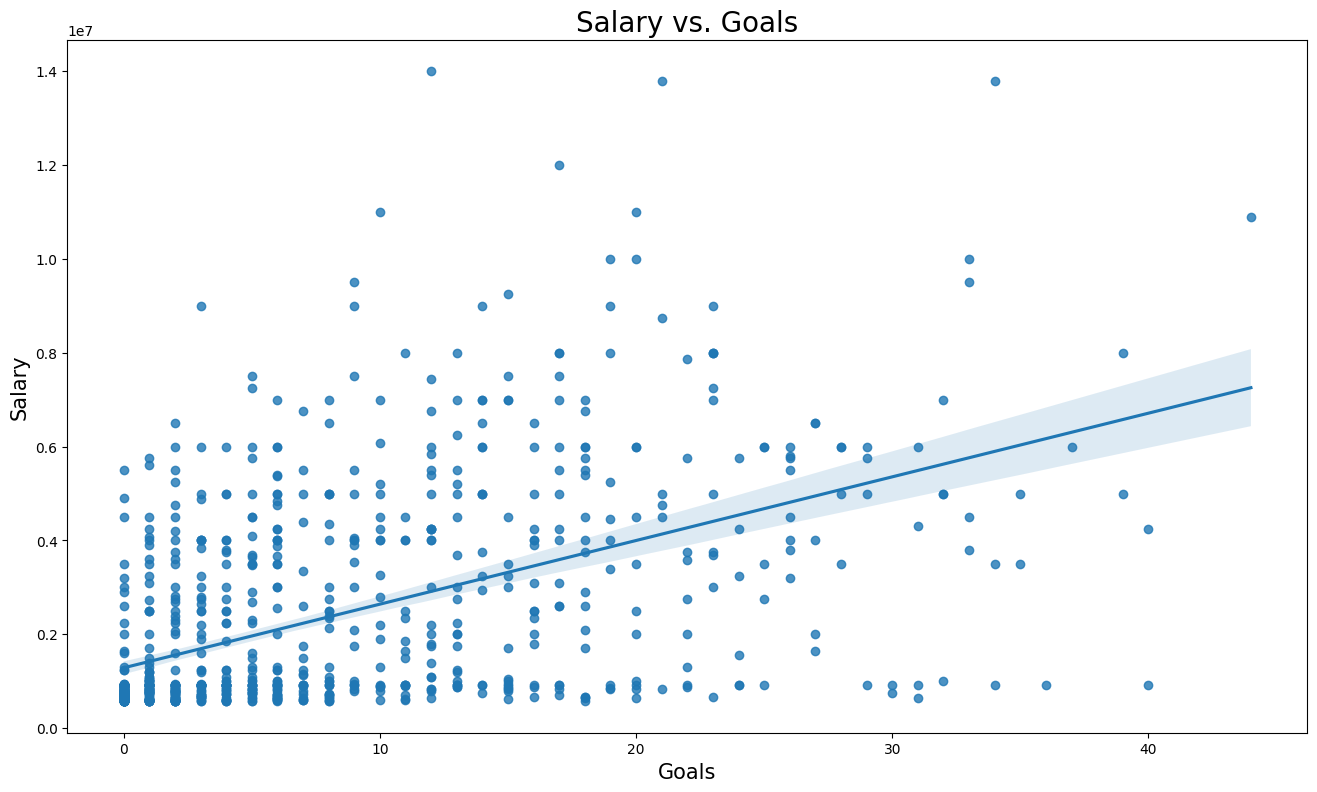

In [53]:
fig, ax = plt.subplots(figsize=(16, 9))

# Use Seaborn's regplot on the axes object
sns.regplot(x='goals', y='salary', data=nhl, ax=ax)

# Adding informative labels
ax.set_xlabel("Goals", fontsize=15)
ax.set_ylabel("Salary", fontsize=15)
ax.set_title('Salary vs. Goals', fontsize=20)

# Display the plot
plt.show()

Adding more variables is also quite straightforward. For instance, if we were to run the following regression: $ \boxed{salary_i = \beta_0 + \beta_1 \cdot goals_i + \beta_2 \cdot games\_played_i + \beta_3 \cdot position\_RW_i + \varepsilon_i} $

In [54]:
# Model 2: Regress the salary on goals and games_played
# Note that position_RW is a dummy/indicator variable and it's coefficient will be interpretted slightly differently
regression2 = smf.ols('salary ~ goals + games_played + position_RW', data=nhl).fit()
print(regression2.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     126.7
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           4.34e-68
Time:                        00:34:21   Log-Likelihood:                -13883.
No. Observations:                 874   AIC:                         2.777e+04
Df Residuals:                     870   BIC:                         2.779e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            6.225e+05   1

##### sklearn

`sklearn` is a machine learning library that focuses on predictions (whereas `StatsModels` is better designed for inference). In a couple of weeks, after we deepen our understanding of predicitons, we will introduce this library and begin using it more often.

On your first assignment `StatsModels` will suffice to create regressions on desired variables and return the statistical metrics of the models. The focus of PS01 is to understand the basics of data exploration and fitting regressions.

### Step 3 | Evaluate the Model's Statistical Metrics

To evaluate our regression models we commonly use MSE and R2. We can extract R2 from the regression output generated in the `StatsModels` package. In `StatsModels` we can calculate MSE manually.

As an example, let's create a regression using goals, games plyed, penalty minutes, and our position dummies are our predictors. 

In [55]:
# Model 3: Regress the salary on goals, games_played, penalty_minutes, position_D, position_LW, position_RW
regression3 = smf.ols('salary ~ \
                     goals + games_played + penalty_minutes + position_D + position_LW + position_RW', data=nhl).fit()
print(regression3.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     70.23
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           2.75e-71
Time:                        00:36:36   Log-Likelihood:                -13869.
No. Observations:                 874   AIC:                         2.775e+04
Df Residuals:                     867   BIC:                         2.778e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3.826e+05   1

In [56]:
# extract R2
print("The R2 of our model is:", regression3.rsquared)

# calculate MSE:
# 1. get the predicted values from the model
predicted_y = regression3.predict(nhl.loc[:, ["goals", "games_played", "penalty_minutes", 'position_D', 'position_LW', 'position_RW']])
y = nhl.loc[:, "salary"]
# 2. calculate Mean Squared Error (MSE)
mse = np.mean((y - predicted_y) ** 2)

print("The MSE of our model is:", mse)

The R2 of our model is: 0.3270533788817408
The MSE of our model is: 3550413472810.541


Typically, you would experiment with different regressions using sample splitting and evaluate each model's performance on out-of-sample data to determine which might be the best model (i.e. minimum MSE) out of these options. 

### Step 4 | Applying our Regression Model

Finally, after selecting a model, we can infer what a "simulated" player's salary might be. 

Let's say we would like to predict what a right winger would expect to make if he scored 12 goals in 55 games and had 6 penalty minutes. Following from our knowledge of regressions, we simply "plug in" these values manually for our predictors to calculate the predicted salary of this type of player.

In [57]:
# Create a dataframe for our imaginary player
player_data = {
    "goals": [12],
    "games_played": [55],
    "penalty_minutes": [6],
    "position_D": [0],
    "position_LW": [0],
    "position_RW": [1]
}

player_df = pd.DataFrame(player_data)
player_df

,goals,games_played,penalty_minutes,position_D,position_LW,position_RW
0,12,55,6,0,0,1


In [58]:
# Predict the salay for our imaginay player
regression3.predict(player_df)

0    2.564931e+06
dtype: float64

We would expect a right winger player with 12 goals in 55 games and 6 penalty minutes to have a salary of \$2,564,931.